In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib

# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np 
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import pickle 
from imutils import build_montages 
import os
from IPython.display import Image, display  
from PIL import Image as array_to_image1
import matplotlib.image as mpimg 
%matplotlib inline

In [2]:
# create these folders if they do not exist
def build_path(dirName):
    try:
        os.makedirs(dirName)    
        print("Directory " , dirName ,  " Created ")
    except:
        print("Directory " , dirName ,  " already exists")  

In [3]:

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim, name="encoded")(x)

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		x = Dense(np.prod(volumeSize[1:]))(latent)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)

		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")

		# return the autoencoder model
		return autoencoder

In [4]:

def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs


In [5]:
build_path("output")
build_path("plot output")

Directory  output  already exists
Directory  plot output  already exists


# input parameter

In [6]:

path_of_trained_autoencoder_model_file = input("path to output trained autoencoder. click 'ENTER' key for default value . ") or "output/autoencoder.h5"


path to output trained autoencoder. click 'ENTER' key for default value . 


In [7]:

path_of_output_reconstruction_visualization_file = input("path to output reconstruction visualization file. click 'ENTER' key for default value . ") or "output/recon_vis.png"


path to output reconstruction visualization file. click 'ENTER' key for default value . 


In [8]:

path_of_output_plot_image_file = input("path to output plot file. click 'ENTER' key for default value . ") or "plot output/plot.png"


path to output plot file. click 'ENTER' key for default value . 


In [9]:

# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20 
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

testX_image = testX

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0


[INFO] loading MNIST dataset...


[INFO] building autoencoder...
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 301s 5ms/sample - loss: 0.0181 - val_loss: 0.0111
Epoch 2/20
60000/60000 [==============================] - 292s 5ms/sample - loss: 0.0103 - val_loss: 0.0098
Epoch 3/20
60000/60000 [==============================] - 238s 4ms/sample - loss: 0.0092 - val_loss: 0.0089
Epoch 4/20
60000/60000 [==============================] - 250s 4ms/sample - loss: 0.0086 - val_loss: 0.0083
Epoch 5/20
60000/60000 [==============================] - 250s 4ms/sample - loss: 0.0082 - val_loss: 0.0082
Epoch 6/20
60000/60000 [==============================] - 247s 4ms/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 7/20
60000/60000 [==============================] - 244s 4ms/sample - loss: 0.0077 - val_loss: 0.0075
Epoch 8/20
60000/60000 [==============================] - 229s 4ms/sample - loss: 0.0075 - val_loss: 0.0074
Epoch 9/20
60000/60000 [==============================]

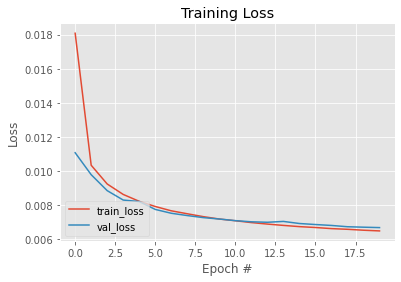

In [10]:

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)



# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(path_of_output_plot_image_file)


# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(path_of_trained_autoencoder_model_file, save_format="h5")


In [11]:

path_of_output_features_index_file = input("path to output features index file. click 'ENTER' key for default value . ") or "output/index.pickle"

# load our autoencoder from disk
print("[INFO] loading autoencoder model...")
autoencoder = load_model(path_of_trained_autoencoder_model_file)


path to output features index file. click 'ENTER' key for default value . 
[INFO] loading autoencoder model...


In [12]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(path_of_output_reconstruction_visualization_file, vis)



[INFO] making predictions...


True

In [13]:

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)


# features trainX

In [14]:

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(trainX)


[INFO] encoding images...


In [15]:

# construct a dictionary that maps the index of the MNIST training
# image to its corresponding latent-space representation
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}


In [16]:

# write the data dictionary to disk
print("[INFO] saving index...")
f = open(path_of_output_features_index_file, "wb")
f.write(pickle.dumps(data))
f.close()


[INFO] saving index...


In [17]:

def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []
	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]

	# return the list of results
	return results

In [18]:

number_of_testing_queries_for_random_selection_of_data = input("# of testing queries to perform. click 'ENTER' key for default value . ") or int(10)


# of testing queries to perform. click 'ENTER' key for default value . 


In [19]:
index = pickle.loads(open(path_of_output_features_index_file, "rb").read())


# features testX

In [20]:

# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)


[INFO] encoding testing images...


In [21]:

# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=number_of_testing_queries_for_random_selection_of_data, 
	replace=False)


In [22]:
output_montage_list_1 = []
query_image_list_1 = [] 

# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=225)
	images = []

	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image = np.dstack([image] * 3)
		images.append(image)

	# display the query image
	query = (testX[i] * 255).astype("uint8")
	query_image_list_1.append(testX_image[i])
	cv2.imshow("Query", query)

        
	# build a montage from the results and display it
	montage = build_montages(images, (28, 28), (15, 15))[0]
	output_montage_list_1.append(montage)
	cv2.imshow("Results", montage)
	cv2.waitKey(0)

0
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



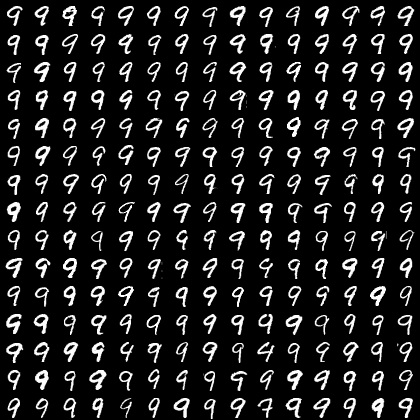

1
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



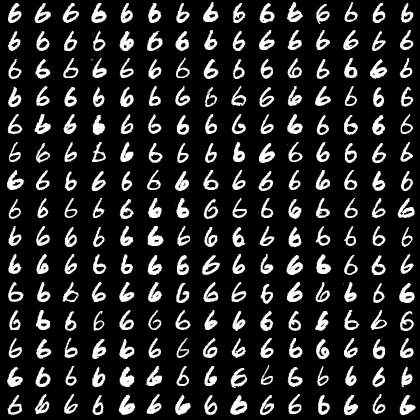

2
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



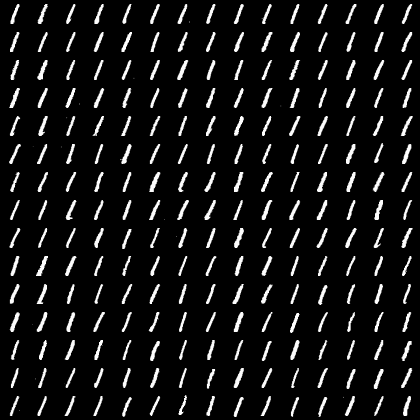

3
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



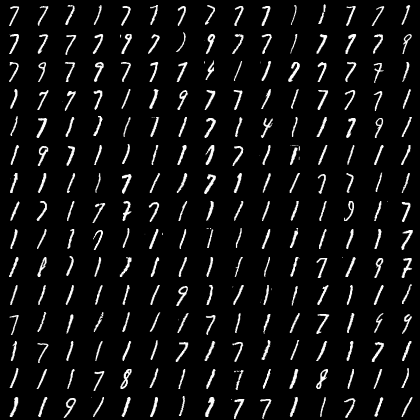

4
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



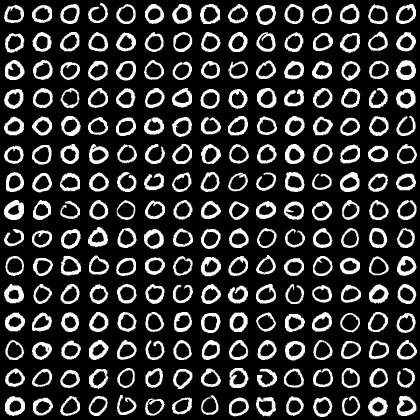

5
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



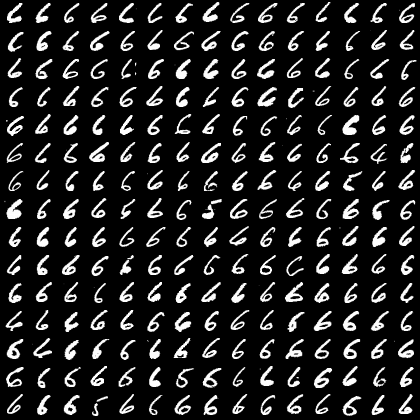

6
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



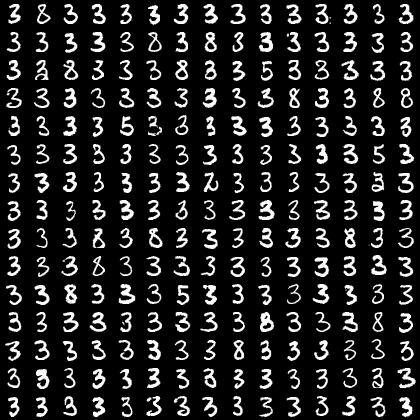

7
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



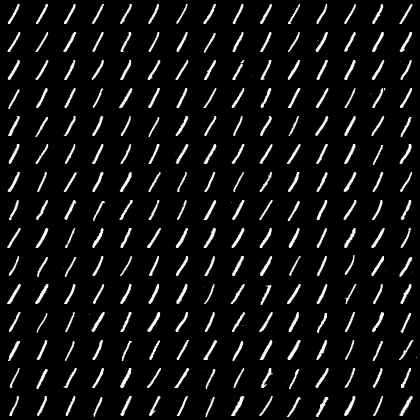

8
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



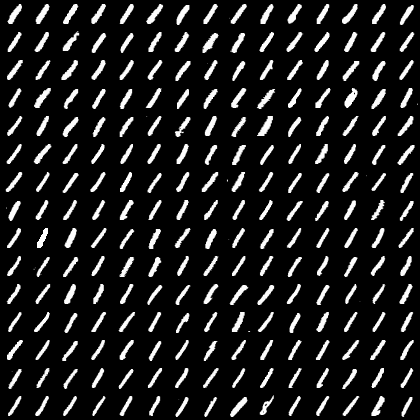

9
  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 




 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



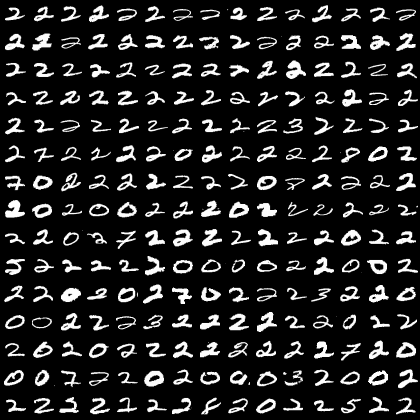


!!!!!!!!!!!!!!!!!!!!!   IMAGE SEARCH OUTPUT PRINT COMPLETED  .   !!!!!!!!!!!!!!!!!!!!!!!!!!!



<Figure size 1872x1368 with 0 Axes>

In [23]:

plt.figure(figsize=(26, 19))

for image_numpy_array_collection in range(len(query_image_list_1)):
    print(image_numpy_array_collection)
    # display the query image
    print(" ", 92*"@", "\n\n", "                      IMAGE USED FOR QUERY : ", " . \n\n ", 92*"@", "\n")
    display(array_to_image1.fromarray(query_image_list_1[image_numpy_array_collection]))
    print("\n", 91*"|","\n")


    print(" ",92*"@", "\n\n", "                       SEARCH OUTPUT : ", " . \n\n ", 92*"@", "\n\n")   
    print("                  image output loading ... .\n")

    display(array_to_image1.fromarray(output_montage_list_1[image_numpy_array_collection]))
        
print("\n!!!!!!!!!!!!!!!!!!!!!   IMAGE SEARCH OUTPUT PRINT COMPLETED  .   !!!!!!!!!!!!!!!!!!!!!!!!!!!\n")    